In [9]:
import numpy as np
import pandas as pd
from os.path import *
from os import getcwd
from os import listdir
from nilmtk.datastore import Key
from nilmtk.measurement import LEVEL_NAMES
from nilmtk.utils import check_directory_exists, get_datastore, get_module_directory
from nilm_metadata import convert_yaml_to_hdf5
from sys import getfilesystemencoding

# Column name mapping
columnNameMapping = {'POWER': ('power', 'active')}

TIMESTAMP_COLUMN_NAME = "TS"
TIMEZONE = "America/Los_Angeles"

def convert_PGE(input_path, output_filename, format='HDF'):
    """
    """
    check_directory_exists(input_path)
    files = [f for f in listdir(input_path) if isfile(join(input_path, f)) and
             '.csv' in f and '.swp' not in f]
    # Sorting Lexicographically
    files.sort()

    # Remove Whole Home and put it at top
    assert isdir(input_path)
    store = get_datastore(output_filename, format, mode='w')
    try:
        for i, csv_file in enumerate(files):
            #Find first line
            with open(join(input_path, csv_file)) as file:
                for line_idx, line in enumerate(file):
                    if (line[0:4] == 'TYPE'):
                        df = pd.read_csv(file, names=['TYPE', 'DATE','START_TIME','END_TIME','POWER','UNITS','COST','NOTES'])
                        break
            key = Key(building=1, meter=(i + 1))
            print('Loading file #', (i + 1), ' : ', csv_file, '. Please wait...')
            # 
            # # Due to fixed width, column names have spaces :(
            df.columns = [x.replace(" ", "") for x in df.columns]
            df[TIMESTAMP_COLUMN_NAME] = df["DATE"] + "T" + df["START_TIME"]
            df.index = pd.to_datetime(df[TIMESTAMP_COLUMN_NAME], format='%Y-%m-%dT%H:%M', utc=False).dt.tz_localize(TIMEZONE)
            df = df.drop(TIMESTAMP_COLUMN_NAME, 1)
            df = df.drop('TYPE', 1)
            df = df.drop( 'DATE', 1)
            df = df.drop('START_TIME', 1)
            df = df.drop('END_TIME', 1)
            df = df.drop('UNITS', 1)
            df = df.drop('COST', 1)
            df = df.drop('NOTES', 1)
            print(df)
            df = df.tz_convert(TIMEZONE)
            df.columns = pd.MultiIndex.from_tuples(
                [columnNameMapping[x] for x in df.columns if x in columnNameMapping],
                names=LEVEL_NAMES
            )
            df = df.apply(pd.to_numeric, errors='ignore')
            df = df.dropna()
            df = df.astype(np.float32)
            print("Adding key", key)
            store.put(str(key), df)
            print("Done with file #", (i + 1))
    finally:    
        store.close()
    metadata_path = join(get_module_directory(), 'dataset_converters', 'ampds', 'metadata')
    print('Processing metadata...')
    convert_yaml_to_hdf5('./metadata', output_filename)
    return df


In [10]:
df = convert_PGE('./data/PGE', 'PGE.h5')

Loading file # 1  :  pge_electric_interval_data_0302750252_2021-02-01_to_2021-09-30.csv . Please wait...
                           POWER
TS                              
2021-02-01 00:00:00-08:00   0.03
2021-02-01 00:15:00-08:00   0.03
2021-02-01 00:30:00-08:00   0.03
2021-02-01 00:45:00-08:00   0.03
2021-02-01 01:00:00-08:00   0.04
...                          ...
2021-09-30 22:45:00-07:00   0.11
2021-09-30 23:00:00-07:00   0.12
2021-09-30 23:15:00-07:00   0.12
2021-09-30 23:30:00-07:00   0.12
2021-09-30 23:45:00-07:00   0.12

[23228 rows x 1 columns]
Adding key /building1/elec/meter1
Done with file # 1
Processing metadata...
Done converting YAML metadata to HDF5!


Plotting...


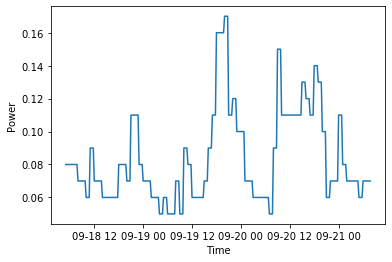

In [21]:
import csv
import matplotlib.pyplot as plt
import numpy as np

print('Plotting...')
#plt.plot(df.index, df["power"])
plt.plot(df.index[22000:22300], df["power"][22000:22300])
plt.xlabel('Time')
plt.ylabel('Power')
# plt.ylim([0, 7])
# indices = np.arange(0, len(df.index) -1, (len(df.index) - 1)//7)
# print(indices)
# plt.xticks(ticks=np.arange(8) * (len(df.index) - 1)//7, labels=np.take(df.index, indices))
plt.show()